In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
sns.set()

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
kq4_data = pd.read_excel('data/KQ4 Workbook.xlsx', sheetname='Sheet1', na_values=['NR', 'NA']).drop(['Notes'], axis=1)
kq4_data.head()

,Author,RefID,LMS Total,Pre-op,Initial Surgery,Morcellation,Power,Cancer Stage,Upstaged,Months follow-up,Outcome,Age,Menopausal Status
0,Einstein,405.0,5.0,Benign,LSC SCC,Yes,Yes,I,No,30.0,NED,NaN,NaN
1,Einstein,405.0,NaN,Benign,LMYOM,Yes,Yes,I to III,Yes,61.0,NED,NaN,NaN
2,Einstein,405.0,NaN,Benign,SCH,Yes,No,I to III,Yes,31.0,AWD,NaN,NaN
3,Einstein,405.0,NaN,Benign,SCH BSO,No,No,I,No,37.0,NED,NaN,NaN
4,Einstein,405.0,NaN,Benign,SCH BSO,No,No,I to IV,Yes,6.0,AWD,NaN,NaN


Some studies show event time truncated to the end of the followup period

In [3]:
followup_event_time = ['Lin', 'Perri', 'Park']
kq4_data['followup_event_time'] = kq4_data.Author.isin(followup_event_time)
kq4_data.followup_event_time.value_counts()

True     127
False     70
Name: followup_event_time, dtype: int64

In [4]:
kq4_data.isnull().mean().round(2)

Author                 0.00
RefID                  0.48
LMS Total              0.91
Pre-op                 0.19
Initial Surgery        0.01
Morcellation           0.01
Power                  0.22
Cancer Stage           0.17
Upstaged               0.81
Months follow-up       0.14
Outcome                0.01
Age                    0.27
Menopausal Status      0.46
followup_event_time    0.00
dtype: float64

In [5]:
kq4_data = kq4_data.dropna(axis='rows', subset=['Months follow-up'])

In [6]:
kq4_data.Outcome.value_counts()

Alive    78
Dead     51
NED      20
AWD      13
Died      8
Name: Outcome, dtype: int64

In [7]:
kq4_data['Pre-op'].value_counts()

Benign    133
Name: Pre-op, dtype: int64

In [8]:
pd.crosstab(kq4_data.Morcellation, kq4_data.Power)

Power,No,Yes
Morcellation,,
No,76,0
Yes,22,30


In [9]:
kq4_data['Initial Surgery'].value_counts()

TAH            73
LSC ASST VH    18
ABD MYOM       12
LSC SCH        11
LSC TVH         8
Varied          7
LSC MYOM        6
H'SCOPE MYO     6
LSC HYST        6
SCH             5
LMYOM           3
TVH             2
VAG HYST        2
TAH UT INJ      2
SCH BSO         2
LAVH            2
MIS HYST        2
TAH BSO         1
LSC SCC         1
Robotic TLH     1
Name: Initial Surgery, dtype: int64

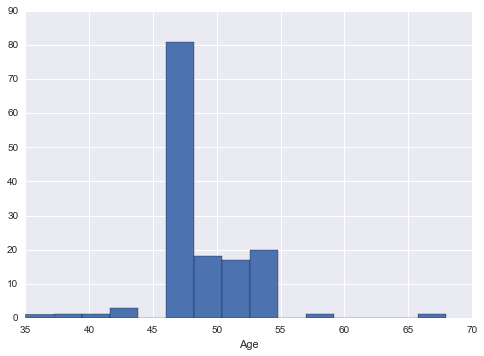

In [10]:
axes = kq4_data.Age.hist(bins=15)
axes.set_xlabel('Age')

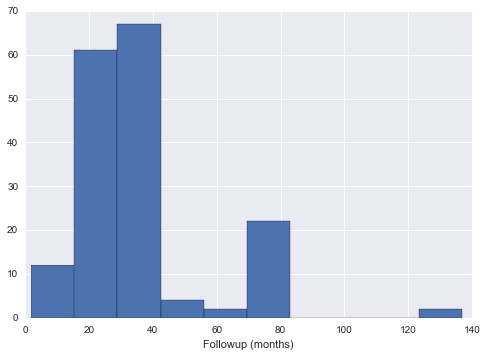

In [11]:
axes = kq4_data['Months follow-up'].hist()
axes.set_xlabel('Followup (months)')

Create death outcome column

In [12]:
kq4_data['died'] = kq4_data.Outcome.isin(['Dead', 'Died'])
kq4_data.loc[kq4_data.Outcome.isnull(), 'died'] = np.nan
kq4_data.died.value_counts()

0.0    111
1.0     59
Name: died, dtype: int64

In [13]:
kq4_data = kq4_data.dropna(subset=['Morcellation', 'Power']).reset_index(drop=True)

In [14]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [15]:
kmf.fit(kq4_data['Months follow-up'], event_observed=kq4_data.died)

<lifelines.KaplanMeierFitter: fitted with 128 observations, 87 censored>

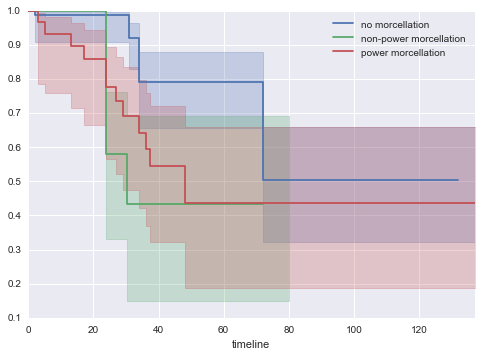

In [16]:
time = kq4_data['Months follow-up']
event = event_observed=kq4_data.died
ix0 = kq4_data.Morcellation=='No'
ix1 = (kq4_data.Morcellation=='Yes') & (kq4_data.Power=='No')
ix2 = (kq4_data.Morcellation=='Yes') & (kq4_data.Power=='Yes')



kmf.fit(time[ix0], event[ix0], label='no morcellation')
ax = kmf.plot()

kmf.fit(time[ix1], event[ix1], label='non-power morcellation')
kmf.plot(ax=ax)

kmf.fit(time[ix2], event[ix2], label='power morcellation')
kmf.plot(ax=ax)

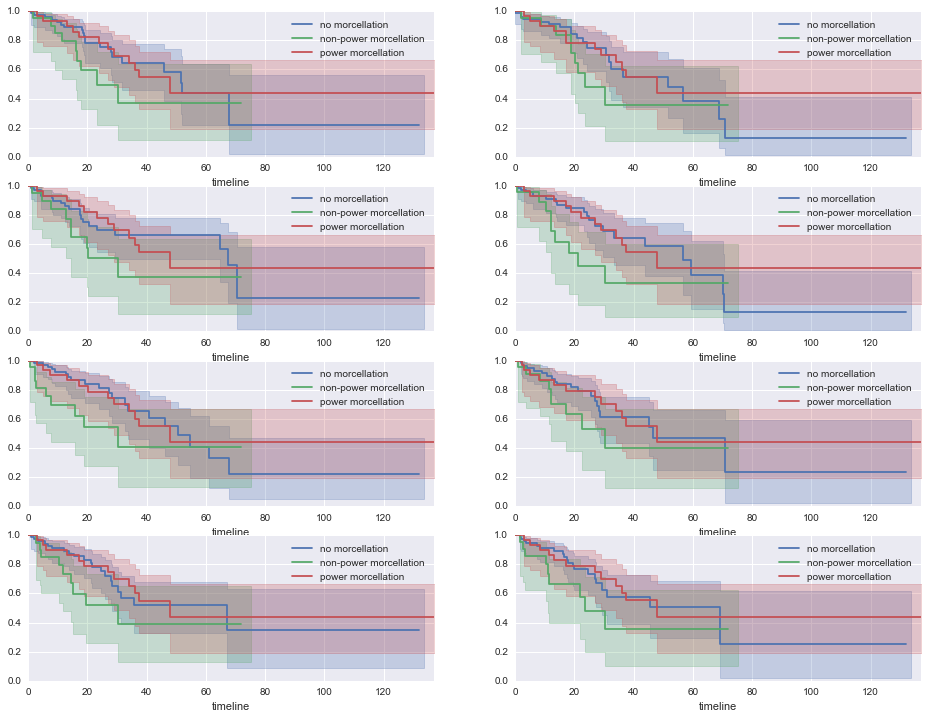

In [17]:
fig, axes = plt.subplots(4,2,figsize=(16,12))

for ax in axes.flatten():
    
    time_sim = kq4_data['Months follow-up'].copy()
    event = event_observed=kq4_data.died
    time_sim.loc[kq4_data.followup_event_time] = np.random.uniform(0, time_sim[kq4_data.followup_event_time])
    
    ix0 = kq4_data.Morcellation=='No'
    ix1 = (kq4_data.Morcellation=='Yes') & (kq4_data.Power=='No')
    ix2 = (kq4_data.Morcellation=='Yes') & (kq4_data.Power=='Yes')

    kmf = KaplanMeierFitter()
    kmf.fit(time_sim[ix0], event[ix0], label='no morcellation')
    kmf.plot(ax=ax)

    kmf.fit(time_sim[ix1], event[ix1], label='non-power morcellation')
    kmf.plot(ax=ax)

    kmf.fit(time_sim[ix2], event[ix2], label='power morcellation')
    kmf.plot(ax=ax)

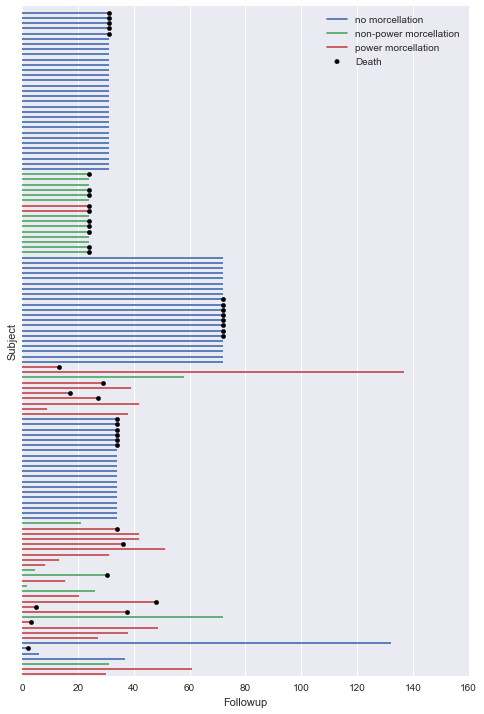

In [18]:
fig, ax = plt.subplots(figsize=(8, 12))
n_patients = kq4_data.shape[0]

blue, green, red = sns.color_palette()[:3]

ax.hlines(kq4_data.index[ix0], 0, time[ix0],
          color=blue, label='no morcellation')

ax.hlines(kq4_data.index[ix1], 0, time[ix1],
          color=green, label='non-power morcellation')

ax.hlines(kq4_data.index[ix2], 0, time[ix2],
          color=red, label='power morcellation')

ax.scatter(time[kq4_data.died == 1], kq4_data.index[kq4_data.died == 1],
           color='k', zorder=10, label='Death');

ax.set_xlim(left=0)
ax.set_ylabel('Subject')
ax.set_xlabel('Followup')
ax.set_yticks([])

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc='upper right');

In [19]:
model_data = (kq4_data.assign(non_power_morcellation=(kq4_data.Morcellation=='Yes') & (kq4_data.Power=='No'))
                      .assign(power_morcellation=(kq4_data.Morcellation=='Yes') & (kq4_data.Power=='Yes')))

In [20]:
time = model_data['Months follow-up']
event = event_observed = model_data.died.astype(int)
n_intervals = int(time.max()+1)
n_patients = model_data.shape[0]

In [21]:
last_period = np.floor(time).astype(int)

death = np.zeros((n_patients, n_intervals))
death[np.arange(n_patients), last_period] = event

In [22]:
interval_bounds = np.arange(0, time.max() + 1, 1)

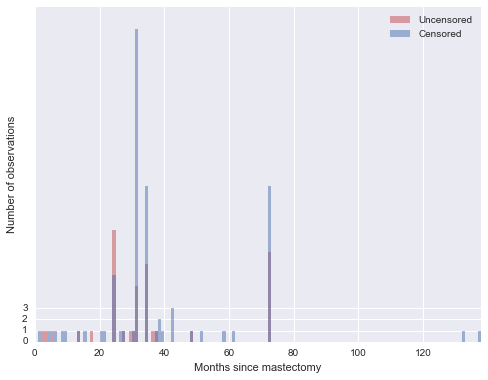

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(time[event==1].values, bins=interval_bounds,
        color=red, alpha=0.5, lw=0,
        label='Uncensored');
ax.hist(time[event==0].values, bins=interval_bounds,
        color=blue, alpha=0.5, lw=0,
        label='Censored');

ax.set_xlim(0, interval_bounds[-1]);
ax.set_xlabel('Months since mastectomy');

ax.set_yticks([0, 1, 2, 3]);
ax.set_ylabel('Number of observations');

ax.legend();

In [25]:
np.greater_equal(np.resize(time, (n_intervals, n_patients)).T, 
                 np.resize(interval_bounds[:-1], (n_patients, n_intervals)))

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ..., 
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]], dtype=bool)

In [26]:
np.resize(time, (n_intervals, n_patients)).T

array([[ 30.,  30.,  30., ...,  30.,  30.,  30.],
       [ 61.,  61.,  61., ...,  61.,  61.,  61.],
       [ 31.,  31.,  31., ...,  31.,  31.,  31.],
       ..., 
       [ 31.,  31.,  31., ...,  31.,  31.,  31.],
       [ 31.,  31.,  31., ...,  31.,  31.,  31.],
       [ 31.,  31.,  31., ...,  31.,  31.,  31.]])

In [27]:
exposure = np.greater_equal.outer(time, interval_bounds[:-1]).astype(int)
exposure[np.arange(n_patients), last_period] = time - interval_bounds[last_period]

In [54]:
time_missing = model_data['Months follow-up'].copy()
time_missing[model_data.followup_event_time] = 1.11
time_masked = np.ma.masked_equal(time_missing, value=1.11)

In [55]:
time_masked.filled()

array([  30.  ,   61.  ,   31.  ,   37.  ,    6.  ,    2.  ,  132.  ,
         27.  ,   38.  ,   48.7 ,    3.  ,   72.  ,   37.5 ,    5.1 ,
         48.  ,   20.2 ,   26.  ,    1.8 ,   15.3 ,   30.4 ,    4.5 ,
          8.  ,   13.  ,   31.  ,   51.  ,   36.  ,   42.  ,   42.  ,
         34.  ,   21.  ,    1.11,    1.11,    1.11,    1.11,    1.11,
          1.11,    1.11,    1.11,    1.11,    1.11,    1.11,    1.11,
          1.11,    1.11,    1.11,    1.11,    1.11,    1.11,    1.11,
          1.11,   38.  ,    9.  ,   42.  ,   27.  ,   17.  ,   39.  ,
         29.  ,   58.  ,  137.  ,   13.  ,    1.11,    1.11,    1.11,
          1.11,    1.11,    1.11,    1.11,    1.11,    1.11,    1.11,
          1.11,    1.11,    1.11,    1.11,    1.11,    1.11,    1.11,
          1.11,    1.11,    1.11,    1.11,    1.11,    1.11,    1.11,
          1.11,    1.11,    1.11,    1.11,    1.11,    1.11,    1.11,
          1.11,    1.11,    1.11,    1.11,    1.11,    1.11,    1.11,
          1.11,    1

In [67]:
import theano.tensor as tt

with pm.Model() as model:
    
    # Impute missing event times
    time_imputed = pm.Uniform('time_imputed', np.zeros(n_patients), time.values, 
                              observed=time_masked, testval=np.ones(n_patients))
    
    last_period = tt.cast(tt.floor(time_imputed), 'int32')

    death = tt.zeros((n_patients, n_intervals))
    death = tt.set_subtensor(death[tt.arange(n_patients), last_period], event)
    
    interval_bounds = tt.arange(0, time_imputed.max() + 2, 1)
    exposure = tt.ge(time_imputed.dimshuffle(0, 'x'), 
                 interval_bounds[:-1].dimshuffle('x', 0))
    exposure = tt.set_subtensor(exposure[np.arange(n_patients), last_period], 
                                time_imputed - interval_bounds[last_period])
    
    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)
    
    beta = pm.Normal('beta', 0, sd=1000, shape=2)
    
    X = model_data[['non_power_morcellation', 'power_morcellation']].values.astype(int)
    
    lambda_ = pm.Deterministic('lambda_', tt.outer(tt.exp(tt.dot(X, beta)), lambda0))
    mu = pm.Deterministic('mu', exposure * lambda_)

    obs = pm.Poisson('obs', mu, observed=death)

Applied log-transform to lambda0 and added transformed lambda0_log to model.


In [63]:
n_iterations = 20000
n_burn = 10000

In [64]:
with model:
    trace = pm.sample(n_iterations, step=pm.Metropolis())

 [-----------------100%-----------------] 20000 of 20000 complete in 61.9 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1241d36a0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x124978dd8>]], dtype=object)

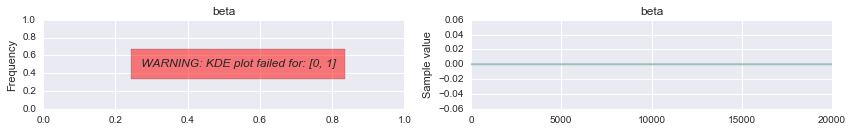

In [65]:
pm.traceplot(trace, varnames=['beta'])

In [27]:
age = kq4_data.Age.copy()
age[kq4_data.Age.isnull()] = -1

In [28]:
from numpy.ma import masked_values
import theano.tensor as T

with pm.Model() as survival_model:
    
    K = 30
    N = kq4_data.shape[0]
    
    alpha_fup = pm.Gamma('alpha_fup', 1., 1.)
    beta_fup = pm.Beta('beta_fup', 1., alpha_fup, shape=K)
    w_fup = pm.Deterministic('w_fup', beta_fup * T.concatenate([[1], T.extra_ops.cumprod(1 - beta_fup[:-1])]))
    fup_component = pm.Categorical('fup_component', w_fup, shape=N)
    
    σ = pm.HalfCauchy('σ', 5, shape=K)
    μ = pm.Normal('μ', 0, 1e-6, shape=K)
    ages = pm.Normal('ages', μ[fup_component], sd=σ[fup_component], observed=masked_values(age, value=-1))                                                           

Applied log-transform to alpha_fup and added transformed alpha_fup_log to model.
Applied logodds-transform to beta_fup and added transformed beta_fup_logodds to model.
Applied log-transform to σ and added transformed σ_log to model.


In [38]:
with survival_model:
    start = pm.find_MAP()
    tr = pm.sample(2000, start=start)

Assigned NUTS to alpha_fup_log
Assigned NUTS to beta_fup_logodds
Assigned ElemwiseCategoricalStep to fup_component
Assigned NUTS to σ_log
Assigned NUTS to μ
Assigned NUTS to ages_missing
 [-----------------100%-----------------] 2000 of 2000 complete in 1380.9 sec

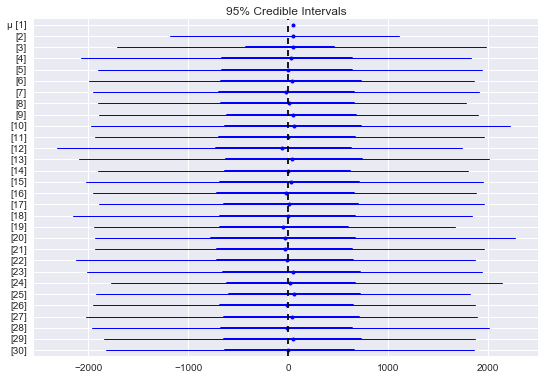

In [39]:
pm.forestplot(tr, varnames=['μ'])

In [40]:
import scipy as sp

x_plot = np.linspace(30, 80, 200)

post_pdf_contribs = sp.stats.norm.pdf(np.atleast_3d(x_plot),
                                      tr['μ'][:, np.newaxis, :],
                                      1. / np.sqrt(tr['σ'])[:, np.newaxis, :])
post_pdfs = (tr['w_fup'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

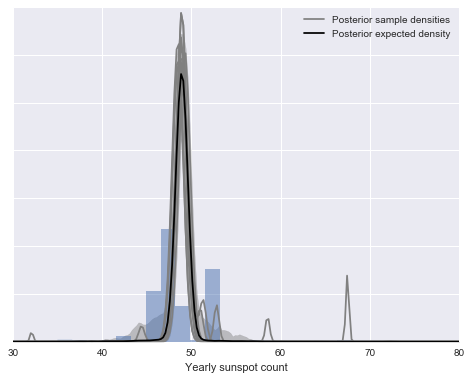

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))

# kq4_data.Age.hist(normed=True, ax=ax, lw=0, bins=20, alpha=0.75)
ax.hist(kq4_data.Age.dropna().values, bins=20, normed=True, lw=0, alpha=0.5);

ax.fill_between(x_plot, post_pdf_low, post_pdf_high,
                 color='gray', alpha=0.45)
ax.plot(x_plot, post_pdfs[0],
        c='gray', label='Posterior sample densities');
ax.plot(x_plot, post_pdfs[::200].T, c='gray');
ax.plot(x_plot, post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density');

ax.set_xlabel('Yearly sunspot count');
ax.set_yticklabels([]);
ax.legend(loc=1);